In [1]:
import numpy as np
import pandas as pd
# import us

import plotly.express as px
import plotly as pl

import microdf as mdf
import plotly.graph_objects as go

from plotly.subplots import make_subplots

import ubicenter

## Exploratory analysis

Use OES data to see workers under \$15 by group:
1. National
2. State & territories
3. State & territories by occupation
3. Metro & non-metro areas
4. Metro & non-metro areas by occupation major code
6. Metro & non-metro areas by occupation detailed

In [2]:
raw = pd.read_csv("data/oes.csv.gz")

/home/mghenis/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (3,12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# select only the necessary columns in the dataset

# only want hourly incomes, percentiles
# want job code to be 00-0000
# what percentage of poeple are in counties/other areas where median income is below 15?\

bls_data = raw.copy(deep=True)

['area', 'area_title', 'area_type', 'naics', 'naics_title', 'i_group', 'own_code', 'occ_code', 'occ_title', 'o_group', 'tot_emp', 'emp_prse', 'jobs_1000_orig', 'loc_quotient', 'pct_total', 'h_mean', 'a_mean', 'mean_prse', 'h_pct10', 'h_pct25', 'h_median', 'h_pct75', 'h_pct90', 'a_pct10', 'a_pct25', 'a_median', 'a_pct75', 'a_pct90', 'annual', 'hourly']


In [59]:
# only want hourly incomes, percentiles
# want job code to be 00-0000
# what percentage of poeple are in counties/other areas where median income is below 15?\

# Drop NAICS out
COLS = ['area', 'area_type', 'area_title',
                                          'occ_code', 'tot_emp', "o_group",
                                          'h_mean', 'h_median', 'h_pct25', 'h_pct75']
bls_data = raw.copy()[raw.naics.isin([0, "000000"])][COLS]

In [60]:
bls_data.o_group.unique()

array(['major', 'detailed', 'broad', 'minor', 'total'], dtype=object)

In [61]:
NUMERICS = ['tot_emp', 'h_mean', 'h_median', 'h_pct25', 'h_pct75']

bls_data[NUMERICS] = bls_data[NUMERICS].apply(pd.to_numeric, errors = 'coerce')

In [62]:
bls_data['wage_level'] = np.where(bls_data[NUMERICS].isnull().any(axis = 'columns'), "N/A", 
                                  np.where(bls_data.h_pct75 < 15, 'p_75 < 15', 
                                           np.where(bls_data.h_median < 15, 'median < 15',
                                                   np.where(bls_data.h_pct25 < 15, 'p_25 < 15',
                                                            'p_25 >= 15'))))

Should be 146,875,480 per https://www.bls.gov/oes/current/oes_nat.htm

In [63]:
bls_data["area_level"] = np.where(bls_data.area_type == 1, "National",
                                  np.where(bls_data.area_type.isin([2, 3]), "States and territories",
                                           np.where(bls_data.area_type.isin([4, 6]),
                                                    "Metro and non-metro areas", "Other")))
bls_data["label"] = bls_data.area_level + " - " + bls_data.o_group

In [64]:
bls_data[bls_data.wage_level != "N/A"].groupby(["label"]).tot_emp.sum()

label
Metro and non-metro areas - detailed    130510010.0
Metro and non-metro areas - major       145269620.0
Metro and non-metro areas - total       146501860.0
National - broad                        134135440.0
National - detailed                     138106940.0
National - major                        146875480.0
National - minor                        137701100.0
National - total                        146875480.0
States and territories - detailed       136835510.0
States and territories - major          147799200.0
States and territories - total          147838700.0
Name: tot_emp, dtype: float64

In [65]:
raw.naics.unique()

array([0, '000000', '113300', '115100', '115200', '211100', '212100',
       '212200', '212300', '213100', '221100', '221200', '221300',
       '236100', '236200', '237100', '237200', '237300', '237900',
       '238100', '238200', '238300', '238900', '311100', '311200',
       '311300', '311400', '311500', '311600', '311700', '311800',
       '311900', '312100', '312200', '313100', '313200', '313300',
       '314100', '314900', '315100', '315200', '315900', '316100',
       '316200', '316900', '321100', '321200', '321900', '322100',
       '322200', '323100', '324100', '3250A1', '3250A2', '325400',
       '326100', '326200', '327000', '331100', '331200', '331300',
       '331400', '331500', '3320A1', '3320A2', '332700', '332800',
       '3330A1', '333300', '333500', '333600', '334100', '334200',
       '334300', '334400', '334500', '334600', '335100', '335200',
       '335300', '335900', '336100', '336200', '336300', '336400',
       '336500', '336600', '336900', '3370A1', '337900', '3

In [66]:
raw[raw.naics == "000000"]

area                                         area_title  area_type  \
196608   46520                                 Urban Honolulu, HI          4   
196609   46520                                 Urban Honolulu, HI          4   
196610   46520                                 Urban Honolulu, HI          4   
196611   46520                                 Urban Honolulu, HI          4   
196612   46520                                 Urban Honolulu, HI          4   
...        ...                                                ...        ...   
395187   79600                                   Worcester, MA-CT          4   
395188  800001  Eastern and Southern Colorado nonmetropolitan ...          6   
395189  800002            Southwest Colorado nonmetropolitan area          6   
395190  800003            Northwest Colorado nonmetropolitan area          6   
395191  900001                   Connecticut nonmetropolitan area          6   

         naics     naics_title         i_group  own_code occ_code  \
196608  000000  Cross-industry  cross-industry      1235  39-9031   
196609  000000  Cross-industry  cross-industry      1235  39-9032   
196610  000000  Cross-industry  cross-industry      1235  39-9041   
196611  000000  Cross-industry  cross-industry      1235  39-9098   
196612  000000  Cross-industry  cross-industry      1235  41-1011   
...        ...             ...             ...       ...      ...   
395187  000000  Cross-industry  cross-industry      1235  00-0000   
395188  000000  Cross-industry  cross-industry      1235  00-0000   
395189  000000  Cross-industry  cross-industry      1235  00-0000   
395190  000000  Cross-industry  cross-industry      1235  00-0000   
395191  000000  Cross-industry  cross-industry      1235  00-0000   

                                                occ_title   o_group  ...  \
196608    Exercise Trainers and Group Fitness Instructors  detailed  ...   
196609                                 Recreation Workers  detailed  ...   
196610                               Residential Advisors  detailed  ...   
196611  Crematory Operators and Personal Care and Serv...  detailed  ...   
196612     First-Line Supervisors of Retail Sales Workers  detailed  ...   
...                                                   ...       ...  ...   
395187                                    All Occupations     total  ...   
395188                                    All Occupations     total  ...   
395189                                    All Occupations     total  ...   
395190                                    All Occupations     total  ...   
395191                                    All Occupations     total  ...   

       h_median h_pct75 h_pct90  a_pct10 a_pct25 a_median a_pct75 a_pct90  \
196608    20.29   27.67   33.84    23370   27780    42200   57560   70390   
196609    14.17   18.97   23.82    23810   26250    29480   39450   49550   
196610    13.74   19.56    23.7    22680   24360    28580   40690   49290   
196611    10.54   10.88   15.15    21910   21910    21920   22630   31500   
196612    21.01   28.64   37.59    25260   33770    43700   59570   78180   
...         ...     ...     ...      ...     ...      ...     ...     ...   
395187    21.15   32.76   48.03    25630   30450    44000   68140   99900   
395188    16.74   23.61   34.28    22690   25400    34820   49110   71300   
395189    17.81   25.53    36.4    22840   26510    37050   53110   75710   
395190     19.9      29   40.96    24320   30770    41400   60320   85190   
395191    20.56   30.77   45.01    24210   30250    42770   63990   93610   

       annual hourly  
196608    NaN    NaN  
196609    NaN    NaN  
196610    NaN    NaN  
196611    NaN    NaN  
196612    NaN    NaN  
...       ...    ...  
395187    NaN    NaN  
395188    NaN    NaN  
395189    NaN    NaN  
395190    NaN    NaN  
395191    NaN    NaN  

[29897 rows x 30 columns]

In [67]:
raw[raw.naics == 0]

area          area_title  area_type naics     naics_title  \
0          99                U.S.          1     0  Cross-industry   
1          99                U.S.          1     0  Cross-industry   
2          99                U.S.          1     0  Cross-industry   
3          99                U.S.          1     0  Cross-industry   
4          99                U.S.          1     0  Cross-industry   
...       ...                 ...        ...   ...             ...   
196603  46520  Urban Honolulu, HI          4     0  Cross-industry   
196604  46520  Urban Honolulu, HI          4     0  Cross-industry   
196605  46520  Urban Honolulu, HI          4     0  Cross-industry   
196606  46520  Urban Honolulu, HI          4     0  Cross-industry   
196607  46520  Urban Honolulu, HI          4     0  Cross-industry   

               i_group  own_code occ_code  \
0       cross-industry      1235  11-0000   
1       cross-industry      1235  13-0000   
2       cross-industry      1235  15-0000   
3       cross-industry      1235  17-0000   
4       cross-industry      1235  19-0000   
...                ...       ...      ...   
196603  cross-industry      1235  39-5094   
196604  cross-industry      1235  39-6011   
196605  cross-industry      1235  39-6012   
196606  cross-industry      1235  39-7010   
196607  cross-industry      1235  39-9011   

                                             occ_title   o_group  ...  \
0                               Management Occupations     major  ...   
1        Business and Financial Operations Occupations     major  ...   
2                Computer and Mathematical Occupations     major  ...   
3             Architecture and Engineering Occupations     major  ...   
4       Life, Physical, and Social Science Occupations     major  ...   
...                                                ...       ...  ...   
196603                            Skincare Specialists  detailed  ...   
196604                    Baggage Porters and Bellhops  detailed  ...   
196605                                      Concierges  detailed  ...   
196606                          Tour and Travel Guides  detailed  ...   
196607                               Childcare Workers  detailed  ...   

       h_median h_pct75 h_pct90  a_pct10 a_pct25 a_median a_pct75 a_pct90  \
0          50.8   74.16       #    49990   71460   105660  154260       #   
1         33.57   45.61    60.6    39020   52130    69820   94870  126040   
2         42.47   57.47   73.08    45320   62850    88340  119550  152010   
3         39.15   52.87   68.56    45280   60910    81440  109970  142610   
4         32.77   46.24   61.59    36640   49360    68160   96180  128100   
...         ...     ...     ...      ...     ...      ...     ...     ...   
196603    20.38   25.19   36.01    27270   33540    42400   52390   74910   
196604    14.04   18.99   31.69    21920   24530    29200   39490   65920   
196605    17.94   22.97   26.32    23420   28090    37310   47770   54750   
196606    13.37   16.54   18.91    22450   23940    27820   34400   39340   
196607    13.24   15.18   17.98    21910   21930    27550   31570   37400   

       annual hourly  
0         NaN    NaN  
1         NaN    NaN  
2         NaN    NaN  
3         NaN    NaN  
4         NaN    NaN  
...       ...    ...  
196603    NaN    NaN  
196604    NaN    NaN  
196605    NaN    NaN  
196606    NaN    NaN  
196607    NaN    NaN  

[196608 rows x 30 columns]

In [73]:
bls_data.groupby("label").tot_emp.sum()

label
Metro and non-metro areas - detailed    139548710.0
Metro and non-metro areas - major       146250410.0
Metro and non-metro areas - total       146501860.0
National - broad                        141584190.0
National - detailed                     146873470.0
National - major                        146875480.0
National - minor                        145394500.0
National - total                        146875480.0
States and territories - detailed       146437220.0
States and territories - major          147838810.0
States and territories - total          147838700.0
Name: tot_emp, dtype: float64

In [75]:
bls_data_target = bls_data[(bls_data.wage_level != "N/A") & 
                           bls_data.o_group.isin(["total", "major", "detailed"])]
bls_grouped = bls_data_target.groupby(["label", "wage_level"])[["tot_emp"]].sum().reset_index()
# Grab label total for denominator.
bls_label_total = bls_grouped.groupby("label")[["tot_emp"]].sum().reset_index()
bls_label_total.rename(columns={"tot_emp": "tot_emp_label"}, inplace=True)
# Merge and divide.
bls_grouped = bls_grouped.merge(bls_label_total, on="label")
bls_grouped["emp_share"] = bls_grouped.tot_emp / bls_grouped.tot_emp_label

In [76]:
bls_data[bls_data.label == "National - total"]

area  area_type area_title occ_code      tot_emp o_group  h_mean  \
394607    99          1       U.S.  00-0000  146875480.0   total   25.72   

        h_median  h_pct25  h_pct75 wage_level area_level             label  
394607     19.14    13.02    30.88  p_25 < 15   National  National - total

In [77]:
bls_grouped

label   wage_level      tot_emp  \
0   Metro and non-metro areas - detailed  median < 15   20083320.0   
1   Metro and non-metro areas - detailed    p_25 < 15   21832100.0   
2   Metro and non-metro areas - detailed   p_25 >= 15   63640490.0   
3   Metro and non-metro areas - detailed    p_75 < 15   24954100.0   
4      Metro and non-metro areas - major  median < 15   28626800.0   
5      Metro and non-metro areas - major    p_25 < 15   42165920.0   
6      Metro and non-metro areas - major   p_25 >= 15   61062410.0   
7      Metro and non-metro areas - major    p_75 < 15   13414490.0   
8      Metro and non-metro areas - total  median < 15    6142490.0   
9      Metro and non-metro areas - total    p_25 < 15  123067070.0   
10     Metro and non-metro areas - total   p_25 >= 15   17082930.0   
11     Metro and non-metro areas - total    p_75 < 15     209370.0   
12                   National - detailed  median < 15   25570110.0   
13                   National - detailed    p_25 < 15   26398110.0   
14                   National - detailed   p_25 >= 15   65198460.0   
15                   National - detailed    p_75 < 15   20940260.0   
16                      National - major  median < 15   29110250.0   
17                      National - major    p_25 < 15   44718060.0   
18                      National - major   p_25 >= 15   59552580.0   
19                      National - major    p_75 < 15   13494590.0   
20                      National - total    p_25 < 15  146875480.0   
21     States and territories - detailed  median < 15   20411590.0   
22     States and territories - detailed    p_25 < 15   24754340.0   
23     States and territories - detailed   p_25 >= 15   66481160.0   
24     States and territories - detailed    p_75 < 15   25188420.0   
25        States and territories - major  median < 15   27262810.0   
26        States and territories - major    p_25 < 15   46098700.0   
27        States and territories - major   p_25 >= 15   62054220.0   
28        States and territories - major    p_75 < 15   12383470.0   
29        States and territories - total  median < 15     928790.0   
30        States and territories - total    p_25 < 15  138931160.0   
31        States and territories - total   p_25 >= 15    7978750.0   

    tot_emp_label  emp_share  
0     130510010.0   0.153883  
1     130510010.0   0.167283  
2     130510010.0   0.487629  
3     130510010.0   0.191204  
4     145269620.0   0.197060  
5     145269620.0   0.290260  
6     145269620.0   0.420338  
7     145269620.0   0.092342  
8     146501860.0   0.041928  
9     146501860.0   0.840038  
10    146501860.0   0.116606  
11    146501860.0   0.001429  
12    138106940.0   0.185147  
13    138106940.0   0.191143  
14    138106940.0   0.472087  
15    138106940.0   0.151624  
16    146875480.0   0.198197  
17    146875480.0   0.304462  
18    146875480.0   0.405463  
19    146875480.0   0.091878  
20    146875480.0   1.000000  
21    136835510.0   0.149169  
22    136835510.0   0.180906  
23    136835510.0   0.485847  
24    136835510.0   0.184078  
25    147799200.0   0.184458  
26    147799200.0   0.311901  
27    147799200.0   0.419855  
28    147799200.0   0.083786  
29    147838700.0   0.006282  
30    147838700.0   0.939748  
31    147838700.0   0.053969

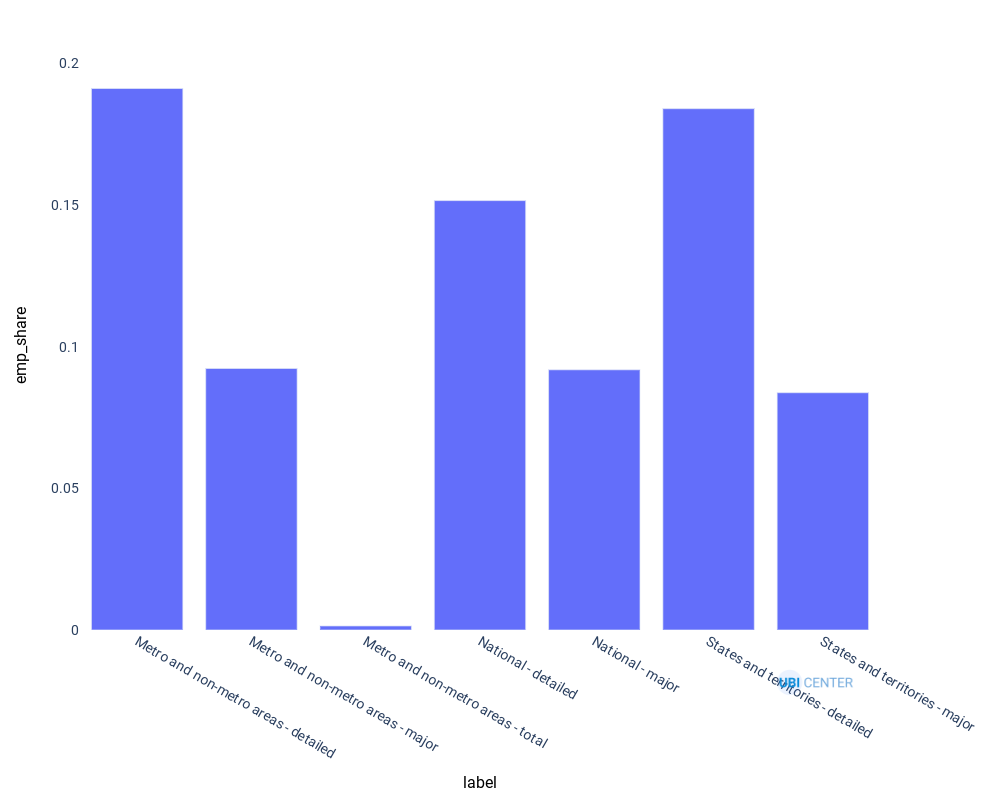

In [78]:
import ubicenter
fig = px.bar(bls_grouped[bls_grouped.wage_level == "p_75 < 15"], "label", "emp_share")
ubicenter.format_fig(fig)

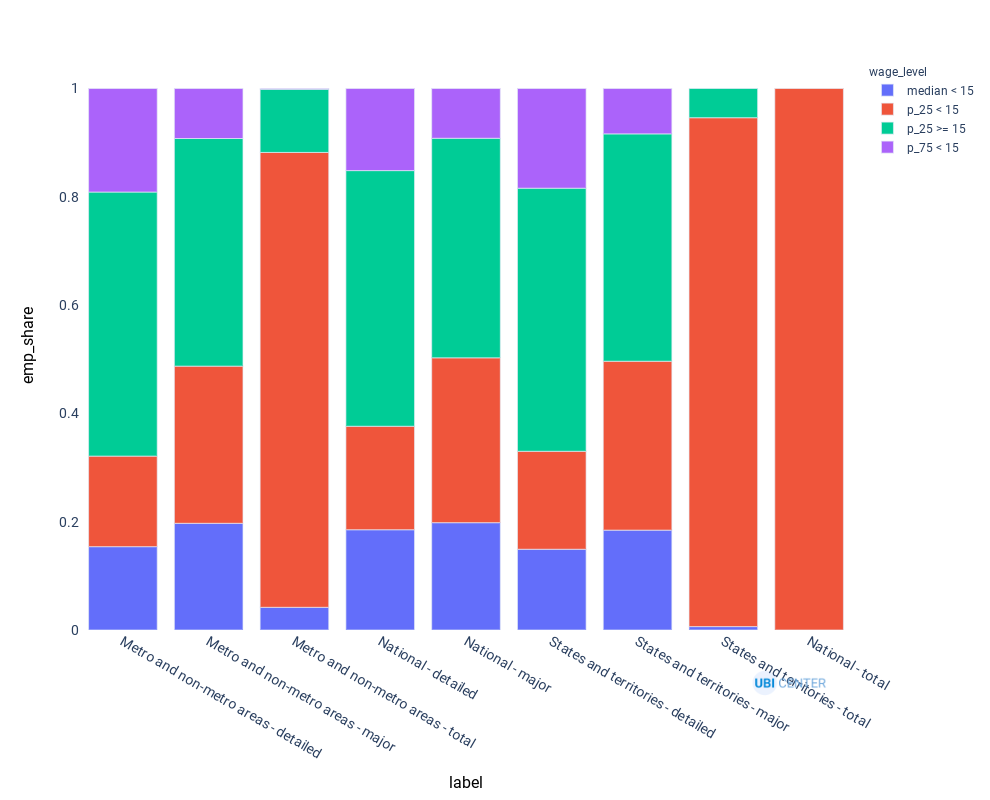

In [79]:
import ubicenter
fig = px.bar(bls_grouped, "label", "emp_share", color="wage_level")
ubicenter.format_fig(fig)

In [ ]:
bls_

In [46]:
raw[raw.occ_code == "00-0000"]

area area_title  area_type   naics  \
394607    99       U.S.          1  000000   
394608     1    Alabama          2  000000   
394609     2     Alaska          2  000000   
394610     4    Arizona          2  000000   
394611     5   Arkansas          2  000000   
...      ...        ...        ...     ...   
395642    99       U.S.          1  622100   
395643    99       U.S.          1  622200   
395644    99       U.S.          1  622200   
395645    99       U.S.          1  622300   
395646    99       U.S.          1  622300   

                                              naics_title             i_group  \
394607                                     Cross-industry      cross-industry   
394608                                     Cross-industry      cross-industry   
394609                                     Cross-industry      cross-industry   
394610                                     Cross-industry      cross-industry   
394611                                     Cross-industry      cross-industry   
...                                                   ...                 ...   
395642             General Medical and Surgical Hospitals  4-digit, ownership   
395643          Psychiatric and Substance Abuse Hospitals  4-digit, ownership   
395644          Psychiatric and Substance Abuse Hospitals  4-digit, ownership   
395645  Specialty (except Psychiatric and Substance Ab...  4-digit, ownership   
395646  Specialty (except Psychiatric and Substance Ab...  4-digit, ownership   

        own_code occ_code        occ_title o_group  ... h_median h_pct75  \
394607      1235  00-0000  All Occupations   total  ...    19.14   30.88   
394608      1235  00-0000  All Occupations   total  ...    16.73   26.34   
394609      1235  00-0000  All Occupations   total  ...    23.34   35.81   
394610      1235  00-0000  All Occupations   total  ...    18.46   28.95   
394611      1235  00-0000  All Occupations   total  ...    15.84   24.26   
...          ...      ...              ...     ...  ...      ...     ...   
395642         5  00-0000  All Occupations   total  ...     28.4   39.98   
395643         2  00-0000  All Occupations   total  ...    22.68   33.58   
395644         5  00-0000  All Occupations   total  ...     21.5   31.28   
395645         2  00-0000  All Occupations   total  ...    30.05   45.08   
395646         5  00-0000  All Occupations   total  ...    29.31    41.8   

       h_pct90  a_pct10 a_pct25 a_median a_pct75 a_pct90 annual hourly  
394607   48.57    21530   27080    39810   64240  101020    NaN    NaN  
394608   39.26    18270   23000    34800   54790   81660    NaN    NaN  
394609   50.33    24560   32390    48540   74480  104690    NaN    NaN  
394610   44.87    23900   27020    38410   60220   93320    NaN    NaN  
394611   36.06    19550   23250    32940   50470   75010    NaN    NaN  
...        ...      ...     ...      ...     ...     ...    ...    ...  
395642   55.78    28450   38120    59070   83160  116020    NaN    NaN  
395643   47.09    25300   32950    47180   69850   97940    NaN    NaN  
395644   43.38    25570   31680    44720   65060   90240    NaN    NaN  
395645   63.88    29070   39850    62490   93770  132870    NaN    NaN  
395646   56.72    28080   38180    60960   86940  117990    NaN    NaN  

[1040 rows x 30 columns]

In [10]:
bls_data_t = bls_data[bls_data.occ_code == '00-0000']

In [11]:
# group by each area level first
# mw_gby_state = min_wage_data.groupby(['STATEFIP']).sum()
# AREA TYPE 6 IS NOT METRO AREA... IT IS NONMETRO AREA

bls_area_states = bls_data_t[bls_data_t.area_type == 2]

bls_area_territories = bls_data_t[bls_data_t.area_type == 3]

bls_area_city = bls_data_t[bls_data_t.area_type == 4]

bls_area_metro_area = bls_data_t[bls_data_t.area_type == 6]

In [12]:
bls_area_states.tot_emp.sum()

146875490.0

In [13]:
bls_area_states
# no state has a median below $15/hour

area  area_type            area_title   naics occ_code     tot_emp  \
394608     1          2               Alabama  000000  00-0000   1974170.0   
394609     2          2                Alaska  000000  00-0000    317090.0   
394610     4          2               Arizona  000000  00-0000   2866820.0   
394611     5          2              Arkansas  000000  00-0000   1217420.0   
394612     6          2            California  000000  00-0000  17382400.0   
394613     8          2              Colorado  000000  00-0000   2678490.0   
394614     9          2           Connecticut  000000  00-0000   1665100.0   
394615    10          2              Delaware  000000  00-0000    451900.0   
394616    11          2  District of Columbia  000000  00-0000    723510.0   
394617    12          2               Florida  000000  00-0000   8794050.0   
394618    13          2               Georgia  000000  00-0000   4471860.0   
394619    15          2                Hawaii  000000  00-0000    635500.0   
394620    16          2                 Idaho  000000  00-0000    727160.0   
394621    17          2              Illinois  000000  00-0000   6025790.0   
394622    18          2               Indiana  000000  00-0000   3073680.0   
394623    19          2                  Iowa  000000  00-0000   1549460.0   
394624    20          2                Kansas  000000  00-0000   1392480.0   
394625    21          2              Kentucky  000000  00-0000   1896900.0   
394626    22          2             Louisiana  000000  00-0000   1921950.0   
394627    23          2                 Maine  000000  00-0000    611170.0   
394628    24          2              Maryland  000000  00-0000   2701010.0   
394629    25          2         Massachusetts  000000  00-0000   3619640.0   
394630    26          2              Michigan  000000  00-0000   4344230.0   
394631    27          2             Minnesota  000000  00-0000   2880650.0   
394632    28          2           Mississippi  000000  00-0000   1128280.0   
394633    29          2              Missouri  000000  00-0000   2820610.0   
394634    30          2               Montana  000000  00-0000    468000.0   
394635    31          2              Nebraska  000000  00-0000    982040.0   
394636    32          2                Nevada  000000  00-0000   1392680.0   
394637    33          2         New Hampshire  000000  00-0000    660480.0   
394638    34          2            New Jersey  000000  00-0000   4087950.0   
394639    35          2            New Mexico  000000  00-0000    823570.0   
394640    36          2              New York  000000  00-0000   9522980.0   
394641    37          2        North Carolina  000000  00-0000   4462800.0   
394642    38          2          North Dakota  000000  00-0000    422520.0   
394643    39          2                  Ohio  000000  00-0000   5447780.0   
394644    40          2              Oklahoma  000000  00-0000   1617390.0   
394645    41          2                Oregon  000000  00-0000   1905860.0   
394646    42          2          Pennsylvania  000000  00-0000   5901590.0   
394647    44          2          Rhode Island  000000  00-0000    483580.0   
394648    45          2        South Carolina  000000  00-0000   2107760.0   
394649    46          2          South Dakota  000000  00-0000    425140.0   
394650    47          2             Tennessee  000000  00-0000   3007710.0   
394651    48          2                 Texas  000000  00-0000  12431200.0   
394652    49          2                  Utah  000000  00-0000   1504070.0   
394653    50          2               Vermont  000000  00-0000    306300.0   
394654    51          2              Virginia  000000  00-0000   3878770.0   
394655    53          2            Washington  000000  00-0000   3318510.0   
394656    54          2         West Virginia  000000  00-0000    702100.0   
394657    55          2             Wisconsin  000000  00-0000   2870050.0   
394658    56          2       

In [14]:
bls_area_territories

# medians are 13.26 for Guam and 10.13 for Puerto Rico

area  area_type      area_title   naics occ_code   tot_emp  h_mean  \
394659    66          3            Guam  000000  00-0000   63630.0   17.75   
394660    72          3     Puerto Rico  000000  00-0000  865160.0   14.27   
394661    78          3  Virgin Islands  000000  00-0000   34420.0   22.10   

        h_median  h_pct25  h_pct75   wage_level  
394659     13.26     9.50    21.27  median < 15  
394660     10.13     8.63    16.03  median < 15  
394661     17.33    12.17    26.29    p_25 < 15

In [15]:
bls_area_city['median_under_15'] = bls_area_city.h_median < 15

bls_area_city['median_under_15'].value_counts()

# 7.56% of cities have a median income below $15/hour

<ipython-input-15-320c3acf732b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bls_area_city['median_under_15'] = bls_area_city.h_median < 15


False    366
True      30
Name: median_under_15, dtype: int64

In [16]:
bls_area_metro_area['median_under_15'] = bls_area_metro_area.h_median < 15

bls_area_metro_area['median_under_15'].value_counts()

# 22.39% of Metro areas have a median income below $15/hour

<ipython-input-16-fbf5fcd3ed9f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bls_area_metro_area['median_under_15'] = bls_area_metro_area.h_median < 15


False    104
True      30
Name: median_under_15, dtype: int64

In [17]:
bls_area_metro_area

area  area_type                                         area_title  \
394662   100001          6             Northwest Alabama nonmetropolitan area   
394663   100002          6             Northeast Alabama nonmetropolitan area   
394664   100003          6             Southwest Alabama nonmetropolitan area   
394665   100004          6             Southeast Alabama nonmetropolitan area   
394684  1200003          6                 South Florida nonmetropolitan area   
...         ...        ...                                                ...   
395170  7200006          6                   Puerto Rico nonmetropolitan area   
395188   800001          6  Eastern and Southern Colorado nonmetropolitan ...   
395189   800002          6            Southwest Colorado nonmetropolitan area   
395190   800003          6            Northwest Colorado nonmetropolitan area   
395191   900001          6                   Connecticut nonmetropolitan area   

         naics occ_code   tot_emp  h_mean  h_median  h_pct25  h_pct75  \
394662  000000  00-0000   65640.0   17.83     15.06    10.78    21.11   
394663  000000  00-0000  147210.0   18.03     14.52    10.48    22.21   
394664  000000  00-0000   67440.0   19.04     15.07    10.31    23.63   
394665  000000  00-0000   86340.0   19.66     15.07    10.48    25.05   
394684  000000  00-0000   77900.0   19.75     16.07    11.48    23.00   
...        ...      ...       ...     ...       ...      ...      ...   
395170  000000  00-0000   17940.0   12.29      9.51     8.51    13.40   
395188  000000  00-0000   68230.0   20.50     16.74    12.21    23.61   
395189  000000  00-0000   99080.0   21.71     17.81    12.74    25.53   
395190  000000  00-0000  122920.0   24.35     19.90    14.79    29.00   
395191  000000  00-0000   32540.0   25.53     20.56    14.55    30.77   

         wage_level  median_under_15  
394662    p_25 < 15            False  
394663  median < 15             True  
394664    p_25 < 15            False  
394665    p_25 < 15            False  
394684    p_25 < 15            False  
...             ...              ...  
395170    p_75 < 15             True  
395188    p_25 < 15            False  
395189    p_25 < 15            False  
395190    p_25 < 15            False  
395191    p_25 < 15            False  

[134 rows x 12 columns]

In [18]:
# use total employees in original dataset

# use number of employees to weigh mean income


# this is the share of employees who are in metro areas w/ median under 15

mdf.weighted_mean(bls_area_metro_area, 'median_under_15', w='tot_emp')

0.21092535752338687

In [19]:
mdf.weighted_sum(bls_area_metro_area, 'median_under_15', w='tot_emp')

3452460.0

In [20]:
bls_area_metro_area.tot_emp.sum()

16368160.0

In [21]:
16368160*0.21092535752338687

3452460.0

In [22]:
# LONG TERM: bar chart, one state, one city, one intersection of city and occupational code



bls_data_t['median_under_15'] = bls_data_t.h_median < 15



<ipython-input-22-0e574e2369c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bls_data_t['median_under_15'] = bls_data_t.h_median < 15


In [23]:
bls_data_t

area  area_type area_title   naics occ_code      tot_emp  h_mean  \
394607    99          1       U.S.  000000  00-0000  146875480.0   25.72   
394608     1          2    Alabama  000000  00-0000    1974170.0   21.60   
394609     2          2     Alaska  000000  00-0000     317090.0   28.51   
394610     4          2    Arizona  000000  00-0000    2866820.0   24.49   
394611     5          2   Arkansas  000000  00-0000    1217420.0   20.52   
...      ...        ...        ...     ...      ...          ...     ...   
395642    99          1       U.S.  622100  00-0000    4689170.0   32.81   
395643    99          1       U.S.  622200  00-0000     115720.0   27.52   
395644    99          1       U.S.  622200  00-0000     128420.0   26.06   
395645    99          1       U.S.  622300  00-0000      32280.0   37.39   
395646    99          1       U.S.  622300  00-0000     232210.0   33.16   

        h_median  h_pct25  h_pct75  wage_level  median_under_15  
394607     19.14    13.02    30.88   p_25 < 15            False  
394608     16.73    11.06    26.34   p_25 < 15            False  
394609     23.34    15.57    35.81  p_25 >= 15            False  
394610     18.46    12.99    28.95   p_25 < 15            False  
394611     15.84    11.18    24.26   p_25 < 15            False  
...          ...      ...      ...         ...              ...  
395642     28.40    18.33    39.98  p_25 >= 15            False  
395643     22.68    15.84    33.58  p_25 >= 15            False  
395644     21.50    15.23    31.28  p_25 >= 15            False  
395645     30.05    19.16    45.08  p_25 >= 15            False  
395646     29.31    18.35    41.80  p_25 >= 15            False  

[1040 rows x 12 columns]

In [24]:
# need to recode area code 3 as 2 (turn territories into states)
# should alsoo filter out area 1, total us, it throws off the scale of the graph
bls_group_to_graph = bls_data_t.groupby(['area_type', 'wage_level'])["tot_emp"].sum().reset_index()

In [25]:
bls_group_to_graph

area_type   wage_level      tot_emp
0           1  median < 15   79705110.0
1           1    p_25 < 15  376237940.0
2           1   p_25 >= 15  321303750.0
3           1    p_75 < 15   44819010.0
4           2    p_25 < 15  138896740.0
5           2   p_25 >= 15    7978750.0
6           3  median < 15     928790.0
7           3    p_25 < 15      34420.0
8           4  median < 15    2707970.0
9           4    p_25 < 15  110385490.0
10          4   p_25 >= 15   16848810.0
11          4    p_75 < 15     191430.0
12          6  median < 15    3434520.0
13          6    p_25 < 15   12681580.0
14          6   p_25 >= 15     234120.0
15          6    p_75 < 15      17940.0

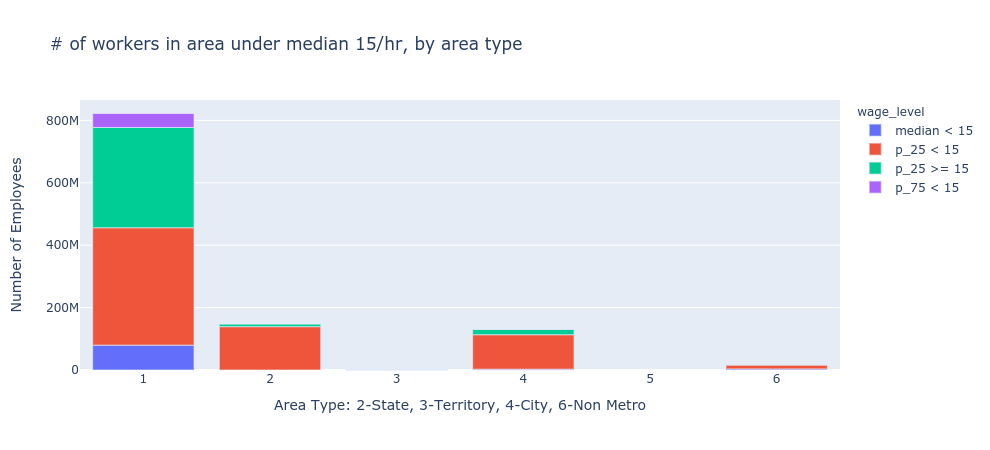

In [26]:
fig = px.bar(bls_group_to_graph, x="area_type", y="tot_emp", color="wage_level", 
             labels={
                     "area_type": "Area Type: 2-State, 3-Territory, 4-City, 6-Non Metro",
                     "tot_emp": "Number of Employees",
                     "median_under_15": "Is the Median Wage of the Area below $15/Hour?"
                 },
             title="# of workers in area under median 15/hr, by area type")
fig.show()

In [27]:
# df[df.Length > 7]

bls_no_tot_us_for_graph = bls_group_to_graph[bls_group_to_graph.area_type != 1]


bls_no_tot_us_for_graph

area_type   wage_level      tot_emp
4           2    p_25 < 15  138896740.0
5           2   p_25 >= 15    7978750.0
6           3  median < 15     928790.0
7           3    p_25 < 15      34420.0
8           4  median < 15    2707970.0
9           4    p_25 < 15  110385490.0
10          4   p_25 >= 15   16848810.0
11          4    p_75 < 15     191430.0
12          6  median < 15    3434520.0
13          6    p_25 < 15   12681580.0
14          6   p_25 >= 15     234120.0
15          6    p_75 < 15      17940.0

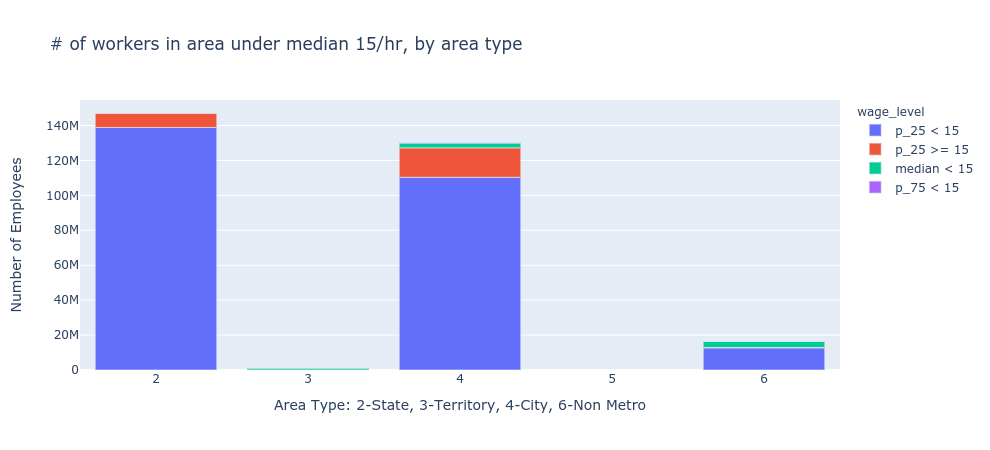

In [28]:
fig_2 = px.bar(bls_no_tot_us_for_graph, x="area_type", y="tot_emp", 
               color="wage_level", 
               labels={
                     "area_type": "Area Type: 2-State, 3-Territory, 4-City, 6-Non Metro",
                     "tot_emp": "Number of Employees",
                     "median_under_15": "Is the Median Wage of the Area below $15/Hour?"
                 },
               title="# of workers in area under median 15/hr, by area type")
fig_2.show()


# within the 4 & 6 area code with occupational codes

In [29]:
data_for_graph_recode = bls_no_tot_us_for_graph.copy(deep = True)

data_for_graph_recode

area_type   wage_level      tot_emp
4           2    p_25 < 15  138896740.0
5           2   p_25 >= 15    7978750.0
6           3  median < 15     928790.0
7           3    p_25 < 15      34420.0
8           4  median < 15    2707970.0
9           4    p_25 < 15  110385490.0
10          4   p_25 >= 15   16848810.0
11          4    p_75 < 15     191430.0
12          6  median < 15    3434520.0
13          6    p_25 < 15   12681580.0
14          6   p_25 >= 15     234120.0
15          6    p_75 < 15      17940.0

In [30]:
data_for_graph_recode['area_type'] = np.where((data_for_graph_recode.area_type == 6), 4, data_for_graph_recode.area_type)




In [31]:
data_for_graph_recode['area_type'] = np.where((data_for_graph_recode.area_type == 3), 2, data_for_graph_recode.area_type)

data_for_graph_recode

area_type   wage_level      tot_emp
4           2    p_25 < 15  138896740.0
5           2   p_25 >= 15    7978750.0
6           2  median < 15     928790.0
7           2    p_25 < 15      34420.0
8           4  median < 15    2707970.0
9           4    p_25 < 15  110385490.0
10          4   p_25 >= 15   16848810.0
11          4    p_75 < 15     191430.0
12          4  median < 15    3434520.0
13          4    p_25 < 15   12681580.0
14          4   p_25 >= 15     234120.0
15          4    p_75 < 15      17940.0

In [32]:
# regroup

data_for_graph_recode_group = data_for_graph_recode.groupby(['area_type', 'wage_level'])["tot_emp"].sum().reset_index()


data_for_graph_recode_group

area_type   wage_level      tot_emp
0          2  median < 15     928790.0
1          2    p_25 < 15  138931160.0
2          2   p_25 >= 15    7978750.0
3          4  median < 15    6142490.0
4          4    p_25 < 15  123067070.0
5          4   p_25 >= 15   17082930.0
6          4    p_75 < 15     209370.0

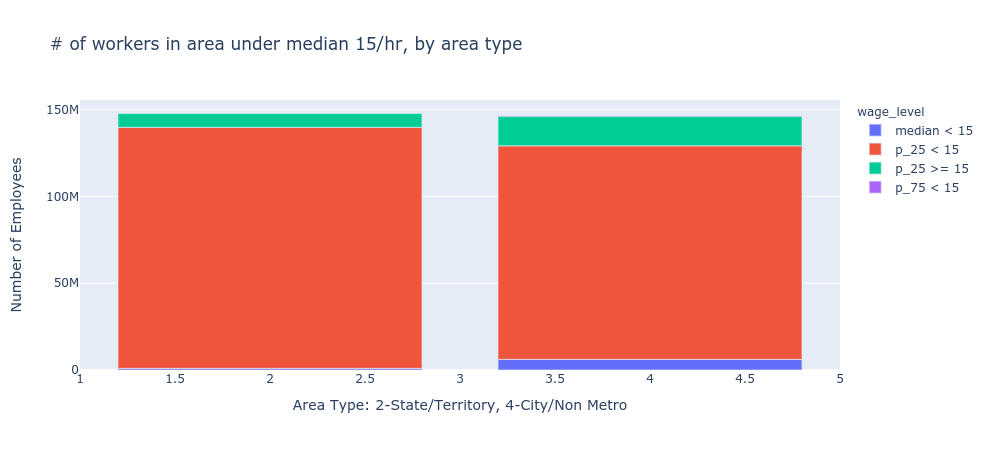

In [33]:
fig_3 = px.bar(data_for_graph_recode_group, x="area_type", y="tot_emp", 
               color="wage_level", 
               labels={
                     "area_type": "Area Type: 2-State/Territory, 4-City/Non Metro",
                     "tot_emp": "Number of Employees",
                     "median_under_15": "Is the Median Wage of the Area below $15/Hour?"
                 },
               title="# of workers in area under median 15/hr, by area type")
fig_3.show()

In [34]:
# do occ code granularity

# bls_data_t[bls_data_t.area_type == 4]

# np.where((df['Salary_in_1000']>=100) & (df['Age']< 60) & (df['FT_Team'].str.startswith('S')))

granular_all_occ_code = bls_data[bls_data.area_type == 4]

granular_all_occ_code = granular_all_occ_code[granular_all_occ_code.occ_code != '00-0000']

granular_all_occ_code['median_under_15'] = np.where(granular_all_occ_code.h_median.isnull(), np.nan, granular_all_occ_code.h_median < 15)

# data_for_graph_recode['area_type'] = np.where((data_for_graph_recode.area_type == 6), 4, data_for_graph_recode.area_type)

# granular_all_occ_code['median_under_15'] = np.where(granular_all_occ_code['h_median'] < 15, True, False)

# df['hasimage'] = np.where(df['photos']!= '[]', True, False)

granular_all_occ_code.median_under_15.isnull().mean()

0.07142957736561184

In [35]:
# Breaks "AttributeError: 'numpy.ndarray' object has no attribute 'isnull'"
# np.where(granular_all_occ_code.h_median.isnull(), np.nan, granular_all_occ_code.h_median < 15).isnull().mean()

In [36]:
granular_all_occ_code.describe()

area  area_type       tot_emp         h_mean       h_median  \
count  142014.000000   142014.0  1.302950e+05  132685.000000  131870.000000   
mean    32529.346614        4.0  1.952346e+03      26.368563      24.343414   
std     15256.001555        0.0  1.308199e+04      15.220042      12.678173   
min     10180.000000        4.0  3.000000e+01       8.130000       7.690000   
25%     20220.000000        4.0  9.000000e+01      16.450000      15.390000   
50%     31080.000000        4.0  2.300000e+02      22.150000      20.970000   
75%     41620.000000        4.0  7.800000e+02      31.660000      29.560000   
max     79600.000000        4.0  1.356000e+06     137.520000      99.980000   

             h_pct25        h_pct75  median_under_15  
count  132455.000000  131043.000000    131870.000000  
mean       19.718063      30.112379         0.232282  
std        10.464197      15.345350         0.422289  
min         7.260000       8.800000         0.000000  
25%        12.710000      18.800000         0.000000  
50%        16.790000      26.250000         0.000000  
75%        23.540000      37.330000         0.000000  
max        99.920000      99.980000         1.000000

In [37]:
granular_all_occ_code

area  area_type        area_title   naics occ_code  tot_emp  h_mean  \
37227   10180          4       Abilene, TX       0  11-0000   2670.0   43.51   
37228   10180          4       Abilene, TX       0  13-0000   2280.0   32.46   
37229   10180          4       Abilene, TX       0  15-0000    630.0   30.27   
37230   10180          4       Abilene, TX       0  17-0000    770.0   34.83   
37231   10180          4       Abilene, TX       0  19-0000    330.0   28.06   
...       ...        ...               ...     ...      ...      ...     ...   
224306  79600          4  Worcester, MA-CT  000000  53-7062   5490.0   16.23   
224307  79600          4  Worcester, MA-CT  000000  53-7063    150.0   16.60   
224308  79600          4  Worcester, MA-CT  000000  53-7064   1340.0   14.63   
224309  79600          4  Worcester, MA-CT  000000  53-7065   4230.0   15.82   
224310  79600          4  Worcester, MA-CT  000000  53-7081    160.0   21.33   

        h_median  h_pct25  h_pct75   wage_level  median_under_15  
37227      37.51    27.22    51.88   p_25 >= 15              0.0  
37228      29.47    22.11    38.38   p_25 >= 15              0.0  
37229      27.31    21.44    36.98   p_25 >= 15              0.0  
37230      32.11    23.82    43.51   p_25 >= 15              0.0  
37231      25.94    20.27    33.07   p_25 >= 15              0.0  
...          ...      ...      ...          ...              ...  
224306     14.59    12.63    18.45  median < 15              1.0  
224307     15.39    13.68    19.24    p_25 < 15              0.0  
224308     13.44    12.45    15.06  median < 15              1.0  
224309     14.27    12.59    17.71  median < 15              1.0  
224310     22.10    17.17    25.58   p_25 >= 15              0.0  

[142014 rows x 12 columns]

In [38]:
granular_all_occ_code_group = (
    granular_all_occ_code.groupby(["occ_code", "wage_level"])["tot_emp"]
    .sum()
    .reset_index()
)

granular_all_occ_code_group

occ_code   wage_level    tot_emp
0     11-0000          nan   685760.0
1     11-0000    p_25 < 15      440.0
2     11-0000   p_25 >= 15  6599520.0
3     11-1011          nan   123880.0
4     11-1011    p_25 < 15      780.0
...       ...          ...        ...
2957  53-7199  median < 15     9280.0
2958  53-7199          nan       80.0
2959  53-7199    p_25 < 15     2900.0
2960  53-7199   p_25 >= 15     3030.0
2961  53-7199    p_75 < 15     1440.0

[2962 rows x 3 columns]

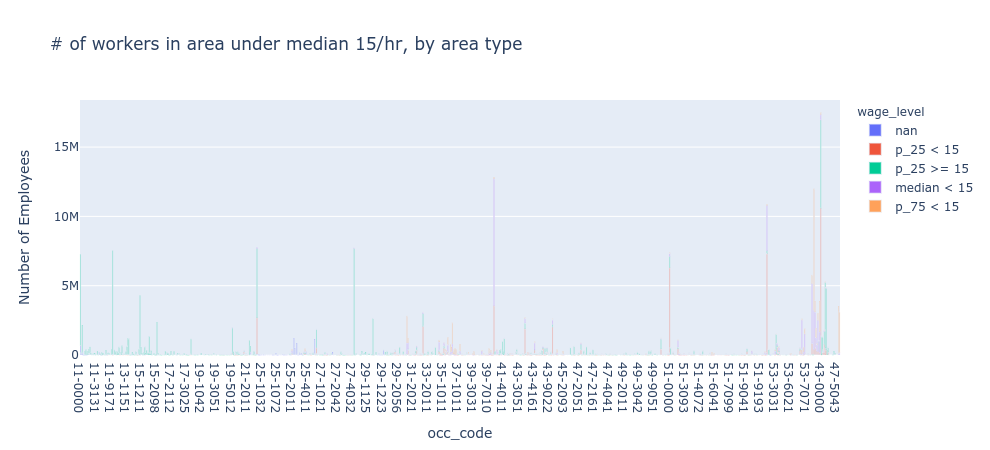

In [39]:
fig_4 = px.bar(granular_all_occ_code_group, x="occ_code", y="tot_emp", 
               color="wage_level", 
               labels={
                     "area_type": "Area Type: 2-State/Territory, 4-City/Non Metro",
                     "tot_emp": "Number of Employees",
                     "median_under_15": "Is the Median Wage of the Area below $15/Hour?"
                 },
               title="# of workers in area under median 15/hr, by area type")
fig_4.show()

In [40]:
# .groupby(['occ_code', 'wage_level'])["tot_emp"].sum().reset_index()

more_gran = granular_all_occ_code_group.groupby('wage_level').sum().reset_index()

more_gran

wage_level      tot_emp
0  median < 15   42479970.0
1          nan    8847690.0
2    p_25 < 15   55911010.0
3   p_25 >= 15  114725260.0
4    p_75 < 15   32416960.0

In [41]:
more_gran

# NEXT STEP
# GROUPING BY GRANULARITY AND WAGE LEVEL, THEN SUM TOTAL EMPLOYEES
# MERGE THAT TO A DATASET SUMMED ONLY BY GRAIN
# DROP NAANS
# interesting to see minimum wage as share of median, not for now though

wage_level      tot_emp
0  median < 15   42479970.0
1          nan    8847690.0
2    p_25 < 15   55911010.0
3   p_25 >= 15  114725260.0
4    p_75 < 15   32416960.0

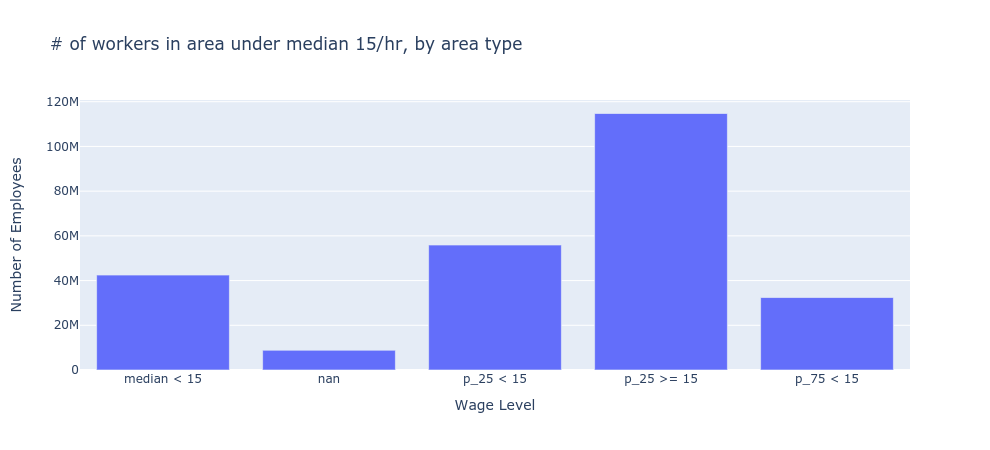

In [42]:
fig_4 = px.bar(more_gran, x="wage_level", y="tot_emp",
               labels={
                     "wage_level": "Wage Level",
                     "tot_emp": "Number of Employees"
                 },
               title="# of workers in area under median 15/hr, by area type")
fig_4.show()

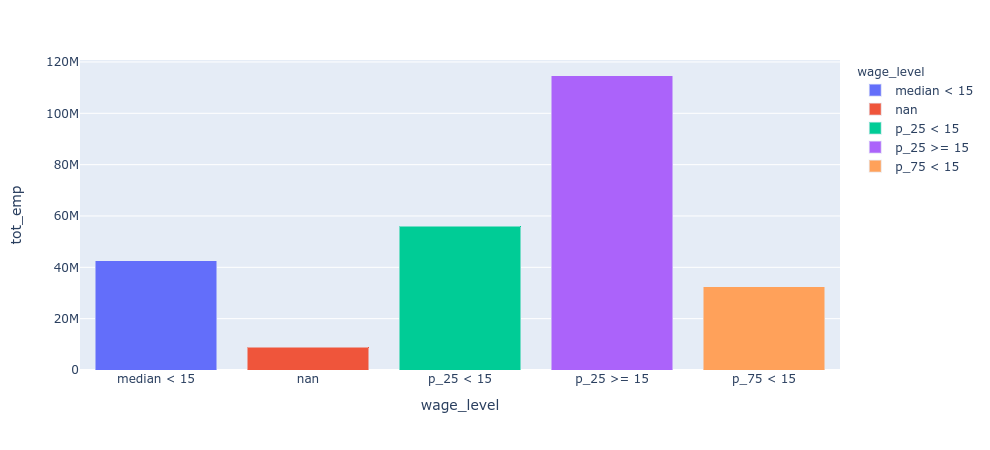

In [43]:
# make the charts stacked percentage charts, mention number of workers covered in each case
# check that nulls are being applied correctly

fig_5 = px.bar(more_gran, x="wage_level", y="tot_emp", color = 'wage_level',barmode = 'stack')
fig_5.show()

In [81]:
# for dist. analysis, bucket people into wage categories, find total people in each category
# Look @ spm resources
# increase/reduce income according to CBO paper-- figure out what % of income that represents and apply to everyone



## Simulation

* add a poverty ratio- offtotval/off cutoff
* https://cps.ipums.org/cps-action/variables/group?id=asec_pov 
* simulate min wage and ubi
* CBO estimate for each income level is aggregated (IN$B)
* get total personal income from IPUMS too, need that to divide into each threshold-- INCTOT

In [82]:
# This is 2020 ASEC (reflecting 2019 income).
cps_data = pd.read_csv("data/cps_00005.csv.gz")

cps_data.INCTOT.replace({999999999:0}, inplace = True)

In [83]:
# Build a dataframe for the CBO data
# make numeric
# change column names
cbo_data = {
    "ratio_of_family_income_to_the_poverty_threshold": [
        "Less than 1.0",
        "1.0 to 1.49",
        "1.5 to 1.99",
        "2.0 to 2.99",
        "3.0 to 5.99",
        "6.0 or More",
    ],
    "earnings_change_billions": [7.14, 5.31, 4.67, 6.66, 8.89, 4.75],
    "income_change_billions": [6.73, 4.53, 3.55, 3.56, -1.96, -24.21],
    "pov_ratio_level": [1, 2, 3, 4, 5, 6],
}

cbo_data_df = pd.DataFrame(cbo_data)

cbo_data_df

ratio_of_family_income_to_the_poverty_threshold  earnings_change_billions  \
0                                   Less than 1.0                      7.14   
1                                     1.0 to 1.49                      5.31   
2                                     1.5 to 1.99                      4.67   
3                                     2.0 to 2.99                      6.66   
4                                     3.0 to 5.99                      8.89   
5                                     6.0 or More                      4.75   

   income_change_billions  pov_ratio_level  
0                    6.73                1  
1                    4.53                2  
2                    3.55                3  
3                    3.56                4  
4                   -1.96                5  
5                  -24.21                6

In [84]:
cps_data['pov_ratio'] = cps_data.OFFTOTVAL/cps_data.OFFCUTOFF

# Simplify with pd.cut.
cps_data['pov_ratio_level'] = np.where(cps_data.pov_ratio < 1, 1, 
                                       np.where(cps_data.pov_ratio <1.5,2, 
                                               np.where(cps_data.pov_ratio < 2, 3,
                                                np.where(cps_data.pov_ratio < 3,4,
                                                np.where(cps_data.pov_ratio < 6, 5,
                                                np.where(cps_data.pov_ratio >=6, 6, None))))))


In [85]:
cps_data.groupby("pov_ratio_level").size()

pov_ratio_level
1    16549
2    12225
3    13395
4    24413
5    50876
6    40501
dtype: int64

In [86]:
cps_data.columns.tolist()

['YEAR',
 'SERIAL',
 'MONTH',
 'CPSID',
 'ASECFLAG',
 'ASECWTH',
 'STATEFIP',
 'COUNTY',
 'PERNUM',
 'CPSIDP',
 'ASECWT',
 'AGE',
 'CITIZEN',
 'DIFFANY',
 'INCTOT',
 'OFFTOTVAL',
 'OFFCUTOFF',
 'POVERTY',
 'SPMWT',
 'SPMTOTRES',
 'SPMNPERS',
 'SPMTHRESH',
 'SPMFAMUNIT',
 'HOURWAGE',
 'QHOURWAG',
 'pov_ratio',
 'pov_ratio_level']

In [87]:
cps2 = mdf.MicroDataFrame(cps_data.merge(cbo_data_df, on = 'pov_ratio_level', how = 'left'),
                          weights="ASECWT")

In [88]:
# Broken - file issue on groupby
# grouped_income_totals = cps2.groupby("pov_ratio_level")[["INCTOT"]].sum()
grouped_income_totals_b = pd.DataFrame(dict(INCTOT=mdf.weighted_sum(cps2, "INCTOT", "ASECWT", "pov_ratio_level") / 1e9)).reset_index()
grouped_income_totals_b = grouped_income_totals_b.merge(cbo_data_df, on = 'pov_ratio_level', how = 'left')

grouped_income_totals_b["pct_inctot_change"] = grouped_income_totals_b.income_change_billions/(grouped_income_totals_b.INCTOT)

grouped_income_totals_b

pov_ratio_level       INCTOT  \
0                1   143.992749   
1                2   254.514587   
2                3   382.648199   
3                4   974.813438   
4                5  3525.343197   
5                6  7448.740650   

  ratio_of_family_income_to_the_poverty_threshold  earnings_change_billions  \
0                                   Less than 1.0                      7.14   
1                                     1.0 to 1.49                      5.31   
2                                     1.5 to 1.99                      4.67   
3                                     2.0 to 2.99                      6.66   
4                                     3.0 to 5.99                      8.89   
5                                     6.0 or More                      4.75   

   income_change_billions  pct_inctot_change  
0                    6.73           0.046738  
1                    4.53           0.017799  
2                    3.55           0.009277  
3                    3.56           0.003652  
4                   -1.96          -0.000556  
5                  -24.21          -0.003250

In [89]:
# TODO: make MicroDataFrame.merge return MicroDataFrame
cps3 = mdf.MicroDataFrame(cps2.merge(grouped_income_totals_b[["pov_ratio_level", "pct_inctot_change"]], on="pov_ratio_level"),
                          weights="ASECWT")
cps3["inc_chg"] = cps3.INCTOT * cps3.pct_inctot_change

Aligns with [CBO report](https://www.cbo.gov/publication/55681) which finds income falls by \$7-8 billion by full phase in of 2027.

In [90]:
cps3

YEAR  SERIAL  MONTH           CPSID  ASECFLAG  ASECWTH  STATEFIP  \
0       2020       1      3  20190302844900         1  1552.90        23   
1       2020       1      3  20190302844900         1  1552.90        23   
2       2020      28      3  20190102848900         1   678.22        23   
3       2020      28      3  20190102848900         1   678.22        23   
4       2020      28      3  20190102848900         1   678.22        23   
...      ...     ...    ...             ...       ...      ...       ...   
157954  2020   91473      3               0         1   404.52        15   
157955  2020   91483      3               0         1   468.26        15   
157956  2020   91483      3               0         1   468.26        15   
157957  2020   91483      3               0         1   468.26        15   
157958  2020   91497      3               0         1   486.02        15   

        COUNTY  PERNUM          CPSIDP  ...  HOURWAGE  QHOURWAG  pov_ratio  \
0            0       1  20190302844901  ...    999.99         0   7.444451   
1            0       2  20190302844902  ...    999.99         0   7.444451   
2            0       1  20190102848901  ...    999.99         0   7.289338   
3            0       2  20190102848902  ...    999.99         0   7.289338   
4            0       3  20190102848903  ...    999.99         0   7.289338   
...        ...     ...             ...  ...       ...       ...        ...   
157954   15003       2               0  ...    999.99         0   1.631659   
157955   15003       1               0  ...    999.99         0   1.580329   
157956   15003       2               0  ...    999.99         0   1.580329   
157957   15003       3               0  ...    999.99         0   1.580329   
157958   15003       1               0  ...    999.99         0   1.665525   

        pov_ratio_level  ratio_of_family_income_to_the_poverty_threshold  \
0                     6                                      6.0 or More   
1                     6                                      6.0 or More   
2                     6                                      6.0 or More   
3                     6                                      6.0 or More   
4                     6                                      6.0 or More   
...                 ...                                              ...   
157954                3                                      1.5 to 1.99   
157955                3                                      1.5 to 1.99   
157956                3                                      1.5 to 1.99   
157957                3                                      1.5 to 1.99   
157958                3                                      1.5 to 1.99   

        earnings_change_billions  income_change_billions  __tmp_weights  \
0                           4.75                  -24.21        1552.90   
1                           4.75                  -24.21        1552.90   
2                           4.75                  -24.21         678.22   
3                           4.75                  -24.21         678.22   
4                           4.75                  -24.21        1087.09   
...                          ...                     ...            ...   
157954                      4.67                    3.55         442.74   
157955                      4.67                    3.55         468.26   
157956                      4.67                    3.55         468.26   
157957                      4.67                    3.55         655.63   
157958                      4.67                    3.55         486.02   

        pct_inctot_change     inc_chg  
0               -0.003250 -170.636227  
1               -0.003250 -243.600278  
2               -0.003250 -487.532077  
3               -0.003250   -0.000000  
4               -0.003250   -0.000000  
...                   ...         ...  
157954           0.009277    8.665139  
157955           0.00927

In [103]:
cps3.inc_chg.sum() / 1e9

-0.0030147355592595126

In [104]:
cps3.columns

Index(['YEAR', 'SERIAL', 'MONTH', 'CPSID', 'ASECFLAG', 'ASECWTH', 'STATEFIP',
       'COUNTY', 'PERNUM', 'CPSIDP', 'ASECWT', 'AGE', 'CITIZEN', 'DIFFANY',
       'INCTOT', 'OFFTOTVAL', 'OFFCUTOFF', 'POVERTY', 'SPMWT', 'SPMTOTRES',
       'SPMNPERS', 'SPMTHRESH', 'SPMFAMUNIT', 'HOURWAGE', 'QHOURWAG',
       'pov_ratio', 'pov_ratio_level',
       'ratio_of_family_income_to_the_poverty_threshold',
       'earnings_change_billions', 'income_change_billions', '__tmp_weights',
       'pct_inctot_change', 'inc_chg'],
      dtype='object')

* Sum up inc_chg by SPM unit
* Add inc_chg to SPM total resources
* Recalculate SPM poverty change
* Make UBI simulation to see how it compares

In [105]:
spmu = mdf.MicroDataFrame(cps3.groupby(["SPMFAMUNIT", "SPMNPERS", "SPMTHRESH", "SPMTOTRES", "SPMWT"])[["inc_chg", "INCTOT"]].sum().reset_index(),
                          weights="SPMWT")

In [128]:
spmu["SPMTOTRES_mw"] = spmu.SPMTOTRES + spmu.inc_chg

In [129]:
spmu.poverty_gap("SPMTOTRES", "SPMTHRESH") / 1e9

157.99418191843998

In [130]:
spmu.poverty_gap("SPMTOTRES_mw", "SPMTHRESH") / 1e9

151.99072144264727

Merge back to person to calculate poverty rates.

In [131]:
cps3.columns

Index(['YEAR', 'SERIAL', 'MONTH', 'CPSID', 'ASECFLAG', 'ASECWTH', 'STATEFIP',
       'COUNTY', 'PERNUM', 'CPSIDP', 'ASECWT', 'AGE', 'CITIZEN', 'DIFFANY',
       'INCTOT', 'OFFTOTVAL', 'OFFCUTOFF', 'POVERTY', 'SPMWT', 'SPMTOTRES',
       'SPMNPERS', 'SPMTHRESH', 'SPMFAMUNIT', 'HOURWAGE', 'QHOURWAG',
       'pov_ratio', 'pov_ratio_level',
       'ratio_of_family_income_to_the_poverty_threshold',
       'earnings_change_billions', 'income_change_billions', '__tmp_weights',
       'pct_inctot_change', 'inc_chg'],
      dtype='object')

In [132]:
# microdataframe bug
pd.DataFrame(spmu)[["SPMFAMUNIT"]]

SPMFAMUNIT
0            1001
1            2001
2            3001
3            4001
4            5001
...           ...
63087    91497001
63088    91498001
63089    91498003
63090    91499001
63091    91500001

[63092 rows x 1 columns]

In [133]:
p = mdf.MicroDataFrame(cps3.merge(pd.DataFrame(spmu)[["SPMFAMUNIT", "SPMTOTRES_mw"]], on="SPMFAMUNIT"), weights="ASECWT")

In [255]:
poverty_mw = p.poverty_rate("SPMTOTRES_mw", "SPMTHRESH")

poverty_change_mw = poverty_mw / p.poverty_rate("SPMTOTRES", "SPMTHRESH") -1

poverty_change_mw

-0.04702772592215465

In [205]:
p.poverty_rate("SPMTOTRES_mw", "SPMTHRESH")

0.11162326658920096

0.03840386909826121

In [254]:
gini_mw = spmu.SPMTOTRES_mw.gini()

gini_change_mw = gini_mw / spmu.SPMTOTRES.gini() - 1

gini_change_mw

-0.005497373186053034

In [218]:
gini_mw

0.46598836636365093

In [137]:
p.columns

Index(['YEAR', 'SERIAL', 'MONTH', 'CPSID', 'ASECFLAG', 'ASECWTH', 'STATEFIP',
       'COUNTY', 'PERNUM', 'CPSIDP', 'ASECWT', 'AGE', 'CITIZEN', 'DIFFANY',
       'INCTOT', 'OFFTOTVAL', 'OFFCUTOFF', 'POVERTY', 'SPMWT', 'SPMTOTRES',
       'SPMNPERS', 'SPMTHRESH', 'SPMFAMUNIT', 'HOURWAGE', 'QHOURWAG',
       'pov_ratio', 'pov_ratio_level',
       'ratio_of_family_income_to_the_poverty_threshold',
       'earnings_change_billions', 'income_change_billions', '__tmp_weights',
       'pct_inctot_change', 'inc_chg', 'SPMTOTRES_mw'],
      dtype='object')

In [ ]:
total_population = p.ASECWT.sum()

total_population

In [117]:
spmu["positive_income"] = np.maximum(spmu.INCTOT, 0)


In [118]:
total_pos_income = spmu.positive_income.sum()


In [177]:
spmu.weights

0        1552.90
1         990.49
2        1505.27
3        1430.70
4        1133.37
          ...   
63087     486.02
63088     444.18
63089     388.29
63090     494.05
63091     423.84
Name: SPMWT, Length: 63092, dtype: float64

## UBI simulation:

* Take a range of UBI amounts, funded by a flat tax on AGI
* Range = np.arange(0, 1000, 10)
* Calculate the poverty rate for each, as well as Gini index

In [183]:
def pov(monthly_ubi):
    cost = monthly_ubi * total_population * 12
    tax_rate = cost/total_pos_income
    spmu['spm_new_tax'] = tax_rate * spmu.positive_income
    spmu['spm_ubi'] = 12 * monthly_ubi * spmu.SPMNPERS
    spmu['new_resources'] = (spmu.SPMTOTRES - spmu.spm_new_tax +
                               spmu.spm_ubi)
    p2 = p.merge(spmu[["SPMFAMUNIT", "new_resources"]], on = "SPMFAMUNIT")
    # need to calculate poverty rate and inequality, use functions in microdf
    p2_mdf = mdf.MicroDataFrame(p2, weights = "ASECWT")
    pov_rate_calc = p2_mdf.poverty_rate("new_resources", "SPMTHRESH")
    gini_calc = spmu.new_resources.gini()
    return pd.Series({"pov":pov_rate_calc, "gini":gini_calc, "tax_rate":tax_rate})









In [187]:
# poverty rate matches at ~ $19/month ubi
# gini also matches at ~ $19/month ubi
# 0.6% flat tax @ $19/month

1 - pov(19)/pov(0)



pov         0.047983
gini        0.005768
tax_rate        -inf
dtype: float64

In [280]:


ubi_vals = pd.Series(np.arange(0, 30, 1))

ubi_sim = ubi_vals.apply(pov)

ubi_sim["ubi_amount"] = ubi_sim.index 


ubi_sim["pov_pct_change"] = ubi_sim.pov/ubi_sim.pov[0] -1


ubi_sim["gini_pct_change"] = ubi_sim.gini/ubi_sim.gini[0] -1





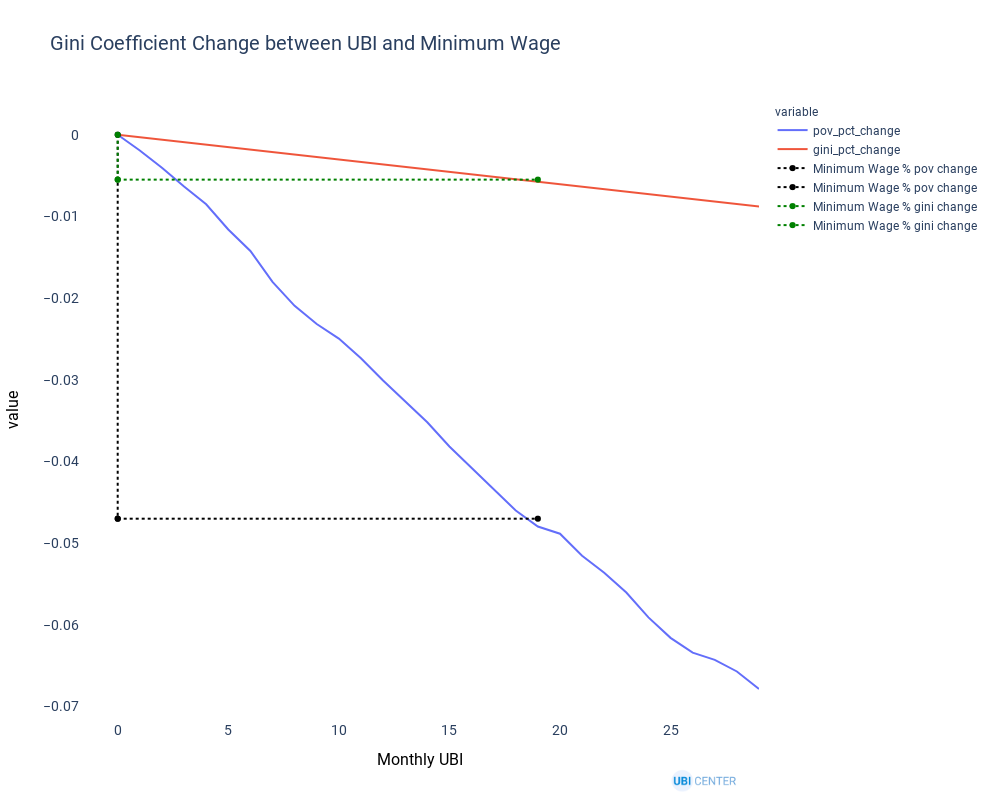

In [281]:
fig_final = px.line(ubi_sim,  x='ubi_amount', y = ['pov_pct_change', 'gini_pct_change'], 
              title= 'Gini Coefficient Change between UBI and Minimum Wage',
             labels= {'ubi_amount':'Monthly UBI', 'gini_pct_change':'Gini %', 'pov_pct_change': 'pov %'})



dash_names = "Minimum Wage % pov change"
dash_color = "black"


fig_final.add_trace(go.Scatter(
    x = [0,19],
    y = [poverty_change_mw, poverty_change_mw],
    name = dash_names,
    line={"dash": "dot", "color": dash_color}
))


fig_final.add_trace(go.Scatter(
    x = [0,0], 
    y = [0, poverty_change_mw],
    name = "Minimum Wage % pov change",
    line={"dash": "dot", "color": dash_color}))



dash_names_gini = "Minimum Wage % gini change"
dash_color_gini = "green"


fig_final.add_trace(go.Scatter(
    x = [0,19],
    y = [gini_change_mw, gini_change_mw],
    name = dash_names_gini,
    line={"dash": "dot", "color": dash_color_gini}
))


fig_final.add_trace(go.Scatter(
    x = [0,0], 
    y = [0, gini_change_mw],
    name = "Minimum Wage % gini change",
    line={"dash": "dot", "color": dash_color_gini}))







#fig_final.show()

ubicenter.format_fig(fig_final)
